In [5]:
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import models
from torchvision import transforms

from tqdm import tqdm

In [6]:
#directory structure
data_directory = "cars_data"
train_df = pd.read_csv(data_directory+"/cars_train_data.csv")
train_images = "cars_data/cars_train/cars_train"
input_dir_cnn = data_directory + "/images/input_images_cnn"

In [7]:
#Resizing all images to the size of 224 X 224 required by ResNet18 model

input_dim = (224,224)

os.makedirs(input_dir_cnn, exist_ok = True)

transformation_for_cnn_input = transforms.Compose([transforms.Resize(input_dim)])

for image_name in os.listdir(train_images):
    I = Image.open(os.path.join(train_images, image_name))
    newI = transformation_for_cnn_input(I)

    newI.save(os.path.join(input_dir_cnn, image_name))

    newI.close()
    I.close()

In [8]:
#Class for getting image embedding vectors after passing through ResNet18

#Each image is converted to a vector of size 512
class Img2VecResnet18():
    def __init__(self):
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor() 
        #Rescaling pixel values between 0 and 1. The values for mean and std was precomputed based on ImageNet dataset
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def getFeatureLayer(self):
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512

        return cnnModel, layer
    #getVec method for getting the corresponding image embeddings
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)
        def copyData(m, i, o): embedding.copy_(o.data)
        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()
        return embedding.numpy()[0, :, 0, 0]

In [9]:
#Creating vectors for every image in the train set
img2vec = Img2VecResnet18()
allVectors = {}

#for larger files we can sequentially write to memory
#since the dataset was small, I'm first storing the values in a dictionary
for image in tqdm(os.listdir(input_dir_cnn)):
    I = Image.open(os.path.join(input_dir_cnn, image))
    try:
        vec = img2vec.getVec(I)
        allVectors[image] = vec
        I.close()
    except:
        pass

100%|███████████████████████████████████████| 8144/8144 [01:46<00:00, 76.75it/s]


In [10]:
#Persisting the vectors in harddisk in csv format

pd.DataFrame(allVectors).transpose().to_csv(data_directory + '/input_data_vectors.csv')

<b>Run everything below if you want to test. Start a spark-shell before running the cells below</b>

In [11]:
#Creating spark session

import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

22/04/27 12:56:03 WARN Utils: Your hostname, dragon resolves to a loopback address: 127.0.1.1; using 192.168.0.199 instead (on interface wlp0s20f3)
22/04/27 12:56:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/04/27 12:56:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/27 12:56:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/27 12:56:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [12]:
#importing image embedding into spark

input_df = spark.read.option('inferSchema', True).csv(data_directory + '/input_data_vectors.csv')

In [13]:
from pyspark.ml.feature import VectorAssembler


#PySpark LSH requires input to be as a vector column. So we are creating it here
vector_columns = input_df.columns[1:]
assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")

output = assembler.transform(input_df)
output = output.select('_c0', 'features')

output.show(1, vertical=True)

22/04/27 12:56:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------
 _c0      | null                 
 features | [0.0,1.0,2.0,3.0,... 
only showing top 1 row



In [14]:
output.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- features: vector (nullable = true)



We are using Locality Sensitive Hashing algorithm for Image similarity search. LSH hashes datapoints to buckets, so that close datapoints are in the same bucket with high probability.

In [15]:
from pyspark.ml.feature import BucketedRandomProjectionLSH #other LSH implementation in PySpark is MinHash
from pyspark.ml.linalg import Vectors

#a larger bucket length leads to fewer buckets and increases probability of data being hashed 
#into same bucket (so many True and False positives)
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", numHashTables=200, bucketLength=2.0)
model = brp.fit(output)

In [16]:
lsh_df = model.transform(output)
lsh_df.show(5)

+---------+--------------------+--------------------+
|      _c0|            features|              hashes|
+---------+--------------------+--------------------+
|     null|[0.0,1.0,2.0,3.0,...|[[5.0], [-42.0], ...|
|01422.jpg|[1.1606774,3.0364...|[[-1.0], [0.0], [...|
|02780.jpg|[0.87709075,1.862...|[[0.0], [0.0], [1...|
|01489.jpg|[0.28539202,4.377...|[[-1.0], [0.0], [...|
|03055.jpg|[0.9969276,2.1145...|[[-1.0], [0.0], [...|
+---------+--------------------+--------------------+
only showing top 5 rows



22/04/27 12:56:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/27 12:56:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


cars_data/images/input_images_cnn/00690.jpg


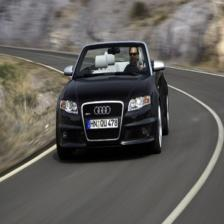

In [30]:
#Nearest neighbour search

from IPython.display import display
from PIL import Image

input_dir_cnn = data_directory + "/images/input_images_cnn"

#testing with a random input image
test_image = os.listdir(input_dir_cnn)[12]
test_image = os.path.join(input_dir_cnn, test_image)
print(test_image)
display(Image.open(test_image))

In [31]:
#First convert the image to vector

img2vec = Img2VecResnet18()
I = Image.open(test_image)
test_vec = img2vec.getVec(I)
I.close()

print(len(test_vec))
print(test_vec)

512
[3.26080233e-01 2.85398388e+00 1.51606810e+00 8.54572579e-02
 3.39279556e+00 4.70073789e-01 2.17633319e+00 8.17963123e-01
 2.88795501e-01 1.34397495e+00 4.53636169e-01 1.26283169e+00
 3.41562182e-01 1.39802742e+00 3.50146554e-02 3.40176761e-01
 7.06961513e-01 1.91733205e+00 9.10504580e-01 4.08622026e-01
 8.32268074e-02 1.75825691e+00 6.16400659e-01 1.07069182e+00
 1.76925778e-01 2.76352024e+00 1.56730235e+00 1.64714456e+00
 1.89201623e-01 2.51516253e-01 1.34959626e+00 2.88583040e-01
 3.12446380e+00 1.26367676e+00 4.16943699e-01 1.57190287e+00
 1.80550247e-01 1.76460624e+00 1.22668815e+00 1.97997034e+00
 2.80575275e-01 9.96812761e-01 2.54569650e-01 2.46575046e+00
 8.23660791e-01 4.81584460e-01 2.35170221e+00 3.14062499e-02
 5.38538516e-01 5.90892971e-01 2.28659123e-01 1.20822914e-01
 1.68132633e-02 3.25617909e-01 2.63501406e-01 1.04253268e+00
 7.06127584e-01 4.90298688e-01 5.55587411e-01 7.34781563e-01
 7.29967713e-01 2.63122395e-02 4.17128354e-01 2.10118338e-01
 1.70561409e+00 1.63

In [32]:
test_vector = Vectors.dense(test_vec)

In [33]:
#doing approximate nearest neighbour search

print("Approximately searching lsh_df for 5 nearest neighbors of the input vector:")
result = model.approxNearestNeighbors(lsh_df, test_vector, 5)

result.show()

Approximately searching lsh_df for 5 nearest neighbors of the input vector:


22/04/27 12:57:22 WARN DAGScheduler: Broadcasting large task binary with size 1050.1 KiB


+---------+--------------------+--------------------+--------------------+
|      _c0|            features|              hashes|             distCol|
+---------+--------------------+--------------------+--------------------+
|00690.jpg|[0.32608023,2.853...|[[0.0], [0.0], [1...|5.468771385119681E-7|
|01297.jpg|[0.30552816,3.538...|[[0.0], [0.0], [0...|   11.78438822790577|
|07777.jpg|[0.5502786,4.1191...|[[-1.0], [0.0], [...|  13.014471869175757|
|08086.jpg|[0.8674804,2.3677...|[[-1.0], [0.0], [...|   13.29445188917551|
|04537.jpg|[0.5320016,3.3066...|[[-1.0], [0.0], [...|  13.525658082147704|
+---------+--------------------+--------------------+--------------------+



22/04/27 12:57:23 WARN DAGScheduler: Broadcasting large task binary with size 1034.1 KiB


22/04/27 12:57:24 WARN DAGScheduler: Broadcasting large task binary with size 1035.0 KiB


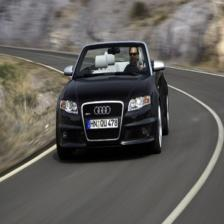

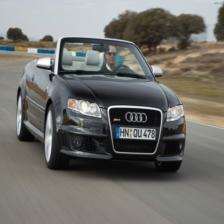

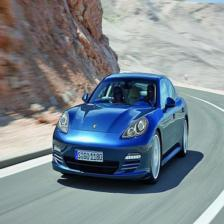

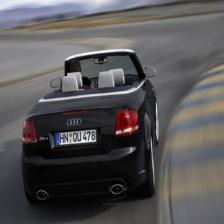

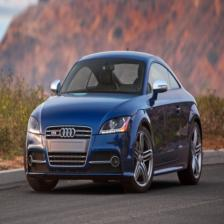

In [34]:
#Top 5 similar images

for i in list(result.select('_c0').toPandas()['_c0']):
    display(Image.open(os.path.join(input_dir_cnn, i)))

In [35]:
list(result.select('_c0').toPandas()['_c0'])

22/04/27 13:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1035.0 KiB


['00690.jpg', '01297.jpg', '07777.jpg', '08086.jpg', '04537.jpg']